# Eularian Fluid Simulation

## Introduction

In this notebook, we simulate the flow of a two-dimensional incompressible fluid using the Eulerian approach and finite difference methods. This simulation is governed by the Navier-Stokes equations:

1. **Conservation of momentum:**

$$
\rho \frac{\partial \vec{u}}{\partial t} + \rho (\vec{u} \cdot \nabla) \vec{u} = -\nabla p + \mu \nabla^2 \vec{u} + \vec{F},
$$

which accounts for the rate of change of momentum in the fluid due to pressure, viscous forces, and external forces.

2. **Continuity equation:**

$$
\nabla \cdot \vec{u} = 0,
$$

which enforces the incompressibility condition, ensuring that the fluid density remains constant.


### Variables and Parameters

- **$\rho$**: Fluid density, a scalar that measures the mass per unit volume.
- **$\vec{u} = (u, v)$**: Velocity vector with components $u$ and $v$ representing the fluid velocity in the $x$- and $y$-directions, respectively.
- **$p$**: Pressure field, a scalar that accounts for the compressive forces within the fluid.
- **$\mu$**: Dynamic viscosity, which quantifies the fluid's resistance to deformation. The kinematic viscosity is defined as $\nu = \frac{\mu}{\rho}$.
- **$\vec{F}$**: External forces, such as gravity or body forces, acting on the fluid.

### Expanded Equations for Two-Dimensional Flow

For an incompressible fluid ($\nabla \cdot \vec{u} = 0$) and no external forces ($\vec{F} = 0$), the Navier-Stokes equations simplify to:

1. **$x$-momentum equation:**

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right),
$$

which describes the changes in the $x$-velocity $u$.

2. **$y$-momentum equation:**

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right),
$$

which describes the changes in the $y$-velocity $v$.

3. **Continuity equation:**

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0,
$$

which ensures mass conservation by maintaining a divergence-free velocity field.

### Numerical Solution Using Finite Differences

To solve these equations numerically, we discretize the domain into a grid and use finite difference methods for spatial and temporal approximations:

1. **First Derivatives (Convective Terms):**

   The central difference scheme is used for convective terms, such as:
   $$
   \frac{\partial u}{\partial x} \approx \frac{u_{i+1,j} - u_{i-1,j}}{2 \Delta x}.
   $$

2. **Second Derivatives (Diffusive Terms):**

   The central difference scheme is also used for diffusive terms, such as:
   $$
   \frac{\partial^2 u}{\partial x^2} \approx \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{\Delta x^2}.
   $$

3. **Pressure-Poisson Equation:**

   The pressure field is computed by solving the pressure-Poisson equation:
   $$
   \nabla^2 p = \rho \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right),
   $$
   using the Gauss-Seidel iterative method, ensuring the velocity field satisfies the incompressibility condition.

### Time Integration

The temporal evolution of the system is calculated using an explicit time-stepping method. The time step size ($\Delta t$) is chosen based on:

- **The Courant-Friedrichs-Lewy (CFL) condition:**

  Ensures stability for convective terms:
  $$
  \Delta t < \frac{\Delta x}{\text{max}(|u|)}.
  $$

- **The viscous stability constraint:**

  Ensures stability for diffusive terms:
  $$
  \Delta t < \frac{\rho \Delta x^2}{\mu}.
  $$

The smaller of these time steps is used to advance the simulation while maintaining numerical stability.

### Simulation Outline

1. **Initialization:**
   Set up the initial velocity and pressure fields.

2. **Boundary Conditions:**
   Apply boundary conditions for velocity and pressure at the walls.

3. **Momentum Equations:**
   Compute intermediate velocity fields without considering pressure contributions.

4. **Pressure Correction:**
   Solve the pressure-Poisson equation to ensure incompressibility and update the velocity fields using the pressure gradient.

5. **Iterate:**
   Advance the simulation by repeating the above steps for the desired number of time steps.

### Conclusion

By following this approach, we can simulate the behavior of incompressible fluid flow with high accuracy. The finite difference method combined with explicit time-stepping and the Gauss-Seidel method for solving the pressure-Poisson equation ensures numerical stability and a computationally efficient solution.


## Setup

In [1]:
# Needed libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # for progress bar
from matplotlib import cm

import PIL
import os
import re
from IPython.display import Image as IPImage, display

In [2]:
# Configuration
plt.rcParams['animation.html'] = 'html5'
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
# Make sure the img directory exists
!mkdir -p img

## Constants and Variables

In [4]:
# Important variables and constants
lx = 1.0 # Length of the domain in meters
ly = 1.0 # Height of the domain in meters
nx = 32 # Number of nodes in the x direction
ny = 32 # Number of nodes in the y direction

# Grid
x = np.linspace(0, lx, nx) # x nodes
dx = x[1] - x[0] # dx

y = np.linspace(0, ly, ny) # y nodes
dy = y[1] - y[0] # dy

xx, yy = np.meshgrid(x, y) # Meshgrid

# COnditions and flow properties
Uwall = 1.0 # Velocity at the top wall in m/s
nu = 0.05
print(f'Reynolds number: {Uwall * ly / nu}')

# Stability condition
dt1 = 0.5 / (nu * (1.0 / dx / dx + 1.0 / dy / dy))
dt2 = 2.0 * nu / (Uwall * Uwall)
dt = min(dt1, dt2)
print(f'Stable timestep size: dt = {dt} s')

# Arrays
u = np.zeros((ny, nx)) # x velocity
v = np.zeros((ny, nx)) # y velocity
p = np.zeros((ny, nx))

# Simulation parameters
t = 0.0
epochs = 10_000
tend = epochs * dt

Reynolds number: 20.0
Stable timestep size: dt = 0.005202913631633714 s


## Helpfull Functions

In [5]:
def apply_boundary_condition(u, v):
    # NOTE: in place operation
    
    # top wall
    u[-1, :] = Uwall
    v[-1, :] = 0.0
    
    # left wall
    u[:, 0] = 0.0
    v[:, 0] = 0.0
    
    # bottom wall
    u[0, :] = 0.0
    v[0, :] = 0.0
    
    # right wall
    u[:, -1] = 0.0
    v[:, -1] = 0.0

In [6]:
# Useful functions
# Helper to compute first and second derivatives
def ddx(_f, _dx):
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (_f[1:-1, 2:] - _f[1:-1, :-2]) / 2.0 / _dx
    return _results

def ddy(_f, _dy):
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (_f[2:, 1:-1] - _f[:-2, 1:-1]) / 2.0 / _dy
    return _results

def laplacian(_f, _dx, _dy):
    # This computes nabla^2 f = d^2 f / dx^2 + d^2 f / dy^2
    _results = np.zeros_like(_f)
    _results[1:-1, 1:-1] = (
        (_f[1:-1, 2:] - 2.0*_f[1:-1, 1:-1] + _f[1:-1, :-2]) / _dx / _dx
        + (_f[2:, 1:-1] - 2.0*_f[1:-1, 1:-1] + _f[2:, 1:-1]) / _dy / _dy
    )
    
    return _results

def divergence(_a, _b, _dx, _dy):
    # This computes div(a, b) = d a / dx + d b / dy
    return ddx(_a, _dx) + ddy(_b, _dy)

In [7]:
def poisson_solver(p, _dx, _dy, _rhs):
    # NOTE: p is modified in place
    
    _tol = 1e-5 # tolerance
    _err = 100
    _maxIt = 50
    _it = 0
    
    while _err > _tol and _it < _maxIt:
        # top wall
        p[-1, :] = 0.0
        
        # bottom wall (Nuemann, dpdy = 0)
        p[0, :] = p[1, :]
        
        # left wall (Nuemann, dpdx = 0)
        p[:, 0] = p[:, 1]
        
        # right wall (Nueman, dpdx = 0)
        p[:, -1] = p[:, -2]
        
        pk = np.zeros_like(p)
        pk[1:-1, 1:-1] = p[1:-1, 1:-1]
        
        for i in range(1, ny-1):
            for j in range(1, nx-1):
                _rhs_copy = (
                    -(dx*dy)**2 * _rhs[j, i] 
                    + dy**2 * (p[j, i+1] + p[j, i-1]) 
                    + dx**2 * (p[j+1, i] + p[j-1, i])
                ) 
                _rhs_copy *= 1.0 / 2.0 / (dx**2 + dy**2)
                p[j, i] = _rhs_copy
                
        _err = np.linalg.norm(p.ravel() - pk.ravel())
        _it += 1
        
    return p, _err # NOTE: p is returned for symbolic reasons

## Simulation

In [8]:
for i in tqdm(range(epochs)):
    if t > tend:
        break # just for safety
    
    # Set the boundary conditions
    apply_boundary_condition(u, v)
    
    # Compute the right-hand side of the momentum equations
    uRHS = -ddx(u*u, dx) - ddy(v*u, dy) + nu * laplacian(u, dx, dy)
    vRHS = -ddx(u*v, dx) - ddy(v*v, dy) + nu * laplacian(v, dx, dy)
    
    # Compute incomplete velocity
    ut = u + dt*uRHS
    vt = v + dt*vRHS
    
    # Build the pressure poisson equation
    prhs = divergence(u, v, dx, dy)/dt + divergence(uRHS, vRHS, dx, dy)
    
    p, err = poisson_solver(p, dx, dy, prhs) # now we have the pressure
    
    dpdx = ddx(p, dx)
    dpdy = ddy(p, dy)
    
    # Time update
    u = u + dt*uRHS - dt*dpdx
    v = v + dt*vRHS - dt*dpdy
    
    # Foward time
    t += dt
    
    # Save the figure (from time to time)
    if i % 10**int(np.log10(i+1)) == 0: # NOTE: logarithmic frequency
        plt.figure(figsize=(10, 6))
        vel = np.sqrt(u**2 + v**2)  # Velocity magnitude
        plt.streamplot(xx, yy, u, v, color=vel, linewidth=1, cmap=cm.coolwarm)
        plt.colorbar(label='Velocity Magnitude')
        plt.title(f"Simulation at Step {i}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim(0, lx)  # Fix x-axis bounds
        plt.ylim(0, ly)  # Fix y-axis bounds
        plt.savefig(f"img/step_{i}.png")  # Save the figure if needed
        plt.close()

100%|██████████| 10000/10000 [11:11<00:00, 14.89it/s]


## Plots and Giffs

GIF saved as assets/evolution.gif


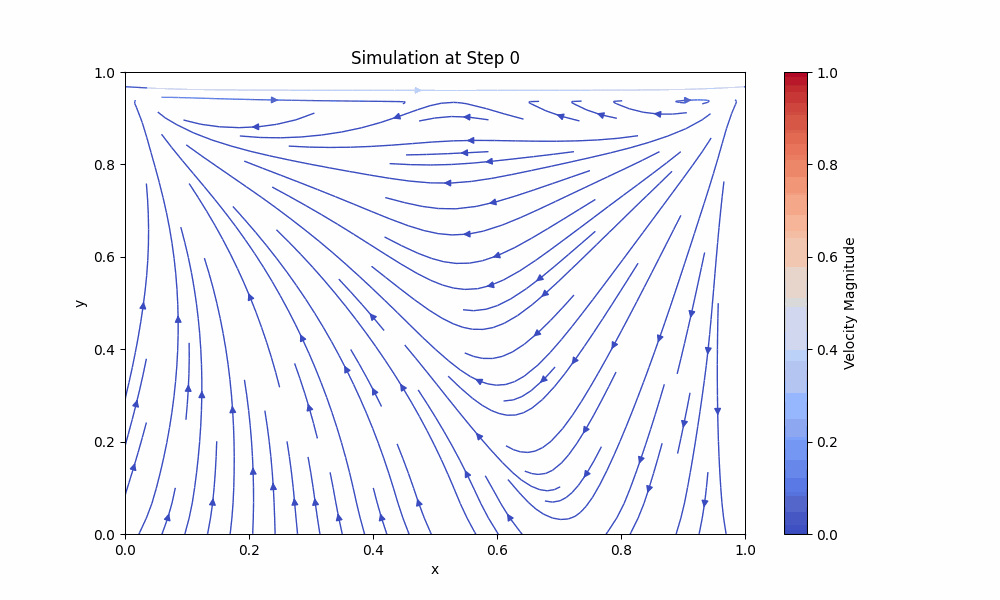

In [9]:
# Directory containing PNG images
image_folder = 'img/'
output_gif = 'assets/evolution.gif'

# Function to extract the number `i` from filenames using a regex
def extract_number(filename):
    match = re.search(r'(\d+)', filename)  # Looks for digits in the filename
    return int(match.group(1)) if match else float('inf')  # Return large number if no match

# Collect all PNG files and sort them by the number in the filename
frames = []
for filename in sorted(os.listdir(image_folder), key=extract_number):
    if filename.endswith('.png'):
        frames.append(PIL.Image.open(os.path.join(image_folder, filename)))

# Ensure there are frames to save
if not frames:
    raise ValueError("No PNG files found in the specified directory!")

# Save as GIF
frames[0].save(
    output_gif,
    save_all=True,
    append_images=frames[1:],
    duration=200,  # Duration in milliseconds per frame
    loop=0  # Loop forever
)

print(f"GIF saved as {output_gif}")

# Display the generated GIF in the notebook
display(IPImage(output_gif))


In [10]:
vel = np.sqrt(u**2 + v**2)  # Velocity magnitude

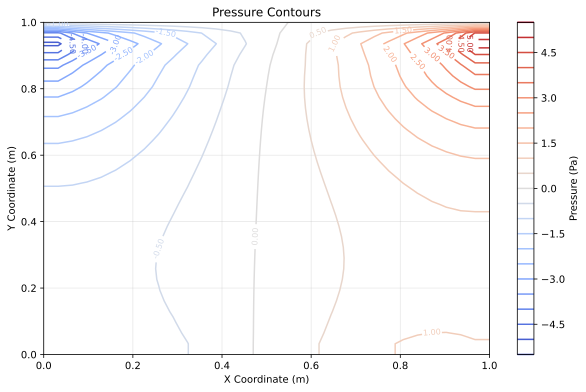

In [11]:
# Pressure contours
plt.figure(figsize=(10, 6))
contour = plt.contour(xx, yy, p, levels=20, cmap='coolwarm')
plt.clabel(contour, inline=True, fontsize=8, fmt="%.2f")  # Add labels to contours
plt.colorbar(contour, label='Pressure (Pa)')  # Add a colorbar for reference
plt.title('Pressure Contours')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(alpha=0.3)
# plt.show()
plt.savefig('assets/pressure_contours.png')

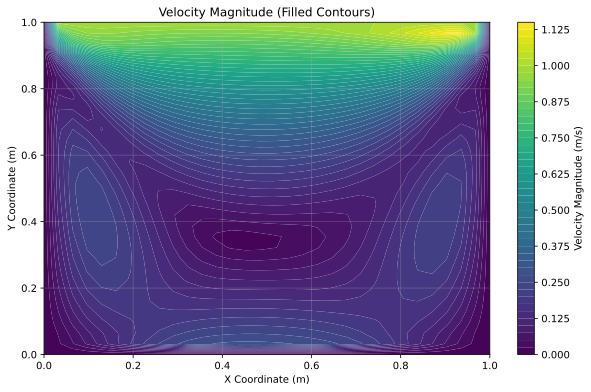

In [12]:
# Velocity magnitude contours
plt.figure(figsize=(10, 6))
contourf = plt.contourf(xx, yy, vel, levels=50, cmap='viridis')  # Smooth gradation with more levels
cbar = plt.colorbar(contourf)
cbar.set_label('Velocity Magnitude (m/s)')
plt.title('Velocity Magnitude (Filled Contours)')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(alpha=0.3)
# plt.show()
plt.savefig('assets/velocity_magnitude_contours.png')


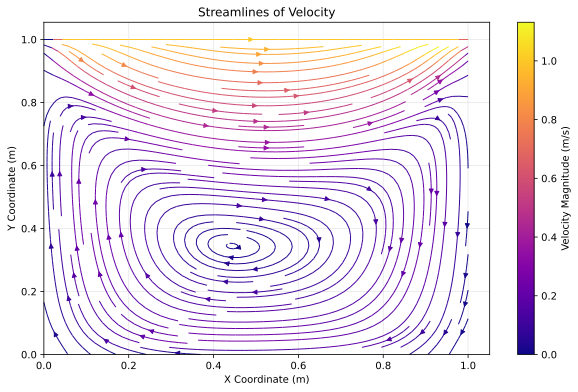

In [13]:

plt.figure(figsize=(10, 6))
plt.streamplot(xx, yy, u, v, color=vel, linewidth=1, cmap='plasma', density=1.5)
cbar = plt.colorbar(label='Velocity Magnitude (m/s)')
plt.title('Streamlines of Velocity')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(alpha=0.3)
# plt.show()
plt.savefig('assets/streamlines.png')

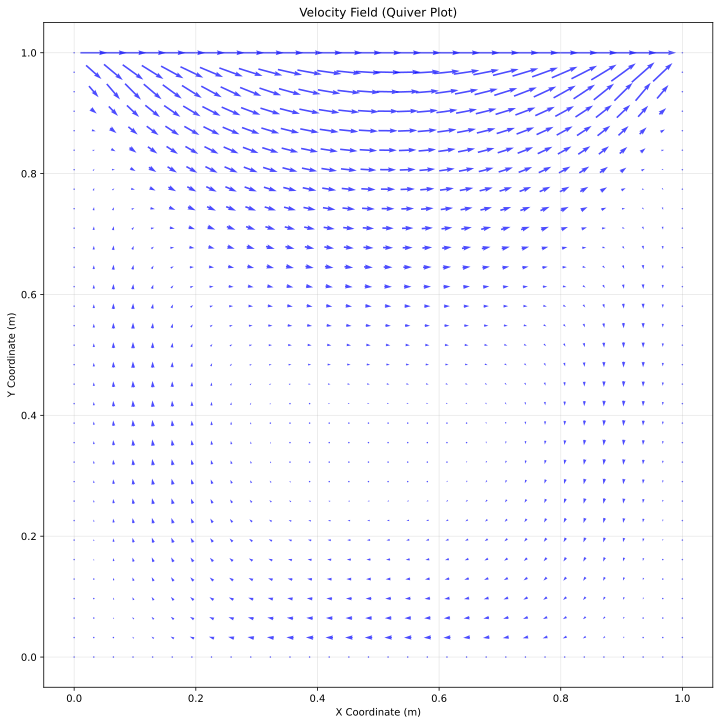

In [14]:
# Quiver plot of the velocity field
plt.figure(figsize=(12, 12))
plt.quiver(xx, yy, u, v, scale=25, angles='xy', pivot='middle', color='blue', alpha=0.7)
plt.title('Velocity Field (Quiver Plot)')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(alpha=0.3)
# plt.show()
plt.savefig('assets/velocity_field.png')

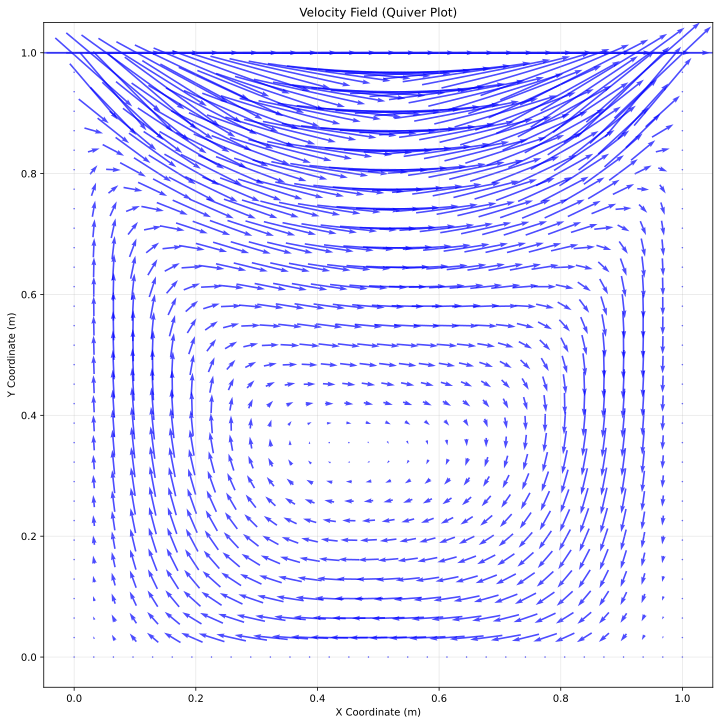

In [15]:
# Quiver plot of the velocity field (scaled up)
plt.figure(figsize=(12, 12))
plt.quiver(xx, yy, u, v, scale=5, angles='xy', pivot='middle', color='blue', alpha=0.7)
plt.title('Velocity Field (Quiver Plot)')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.grid(alpha=0.3)
# plt.show()
plt.savefig('assets/velocity_field_scaled.png')